Versions:
* v1: one full cycle. Not yet multiple cycles implemented
* v2: MORDM cycle into IO-function
    * Can be used for MORDM validation
* v3: restructure into MORDM function
* v4: mpmordm iterative way - Finished
* v5: 
    * Micromodel between iterations
    * Distance table based on OSRM (not used in model, only for distances uncertainty
    * OSRM is not yet integrated in full process. just done once
* v6:
    * start: real distance matrix
    * then: real input data FLs
* v7: Verified that the mordm algorithmic function produces the same result as the decoupled version in MORDM v9 Model Testing

TODO inputdata: 
* FL not random generation
* distances based on OSRM route matrix
* parametrisation sigmoid and linear function

TODO model:
* Check values for disruption 1-2 of 0-1

TODO:
* #Filter out those where no new demand is covered<br>
    #TODO: Works only first time. After that doesn't work.<br>
    #TODO: Change to "not more than previous round"
* XX done via saving: return information about objective prioritisation for each returned nondom policy and nondom robust policy
* better names inputvariables
* Priority: add extra location to non-dominated with highest information yield
* Priority: change info based on locations
* non-random disruption - for after MT?
* non-random uncertainty changes - for after MT?

# Imports

In [1]:
# Standard imports & printing versions
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Own Model import
from lib.fl_model_v8 import *
# import lib.fl_model_v5 as flm

# for natural sorting
import re

#for nondominated sorting
import lib.pareto as pareto
# from lib.list_imports import find_loaded_modules

# for parallel plotting
from lib.parallel_plotting import plot_optimal

# For checking ema running time
import time

import ema_workbench as ema
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

import sys

# for routing table:
import osrm



C:\Users\timro\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
# %load https://gist.github.com/TRomijn/d9d28ba7b7d5eeac1deea5a26dd326b2/raw/loaded_modules.py

'''
original author: kinverarity1

List loaded modules and packages, and show their version numbers
and/or Git repository's HEAD commit SHA.


Changes:
Minor changes to make compatible with Python 3
'''
# Standard library modules
import types
import os

# Third-party packages
import git      # GitPython


def module_path(mod):
    '''Returns path to the file that module *mod* comes from.
    If it doesn't come from a file, return None.'''
    if hasattr(mod, '__file__'):
        return os.path.abspath(os.path.dirname(mod.__file__))
    else:
        return None

    
def from_git_repo(mod):
    '''Does the module *mod* reside in a Git repository?'''
    path = module_path(mod)
    if path:
        try:
            repo = git.Repo(path)
        except:
            return False
        else:
            return True
    else:
        return False

    
def git_path_sha(mod, slice=slice(0, 8, 1)):
    '''Return SHA hash for the HEAD commit for the repository
    that the module *mod* resides in.'''
    repo = git.Repo(module_path(mod))
    return repo.git_dir, repo.head.commit.hexsha[:8]


def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if isinstance(v, str):
                    version.append(v)
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

    
def find_loaded_modules(only_versioned_modules=True):
    '''Return list of loaded modules for which there is a version
    number or a Git repository commit SHA.
    
    Return a list of *(name, version, path_to_git_repo, git_head_sha)*,
    which has an HTML property for pretty display in IPython Notebooks.
        
    '''
    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version', 'Path', 'SHA']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            if from_git_repo(mod):
                path, sha = git_path_sha(mod)
            else:
                path = ''
                sha = ''
            
            version = module_version(mod)
            
            if only_versioned_modules:
                flag = version or (path and sha)
            else:
                flag = True
            
            if flag:
                objs.append([mod.__name__, version, path, sha])
    objs.sort(key=lambda r: r[0])
    return objs


    
    

In [3]:
find_loaded_modules().HTML

Name,Version,Path,SHA
ema_workbench,1.1.3,,
git,2.1.9,,
json,2.0.9,,
lib.pareto,1.1.1-3,,
numpy,1.14.2,,
osrm,0.11.1,,
pandas,0.23.0,,
re,2.2.1,,
sys,"3.6.4 |Anaconda, Inc.| (default, Mar 12 2018, 20:20:50) [MSC v.1900 64 bit (AMD64)]",,


# Data Prep

## Load Data Old

Data is preliminary data. TODO: Find reliable input data

In [4]:
# Create DPs from Nepal Data
DPs = pd.read_csv("Data/Nepal Cities Population.csv", usecols=[1,2,3,4])

# Take only larger cities, because of many null values under 50000 inhabitants. 
# TODO find better dataset with population and coordinates
DPs = DPs [DPs.Population >= 50000]
DPs.head(2)

,City,Population,Latitude (DD),Longitude (DD)
0,Kathmandu,743300,27.71,85.31
1,Biratnagar,178000,26.46,87.28


In [5]:
# Create SPs from Nepal Data
airports = pd.read_csv("Data/Nepal Airports.csv", usecols=[0,5,6])
SPs = airports[airports['Airport'] == "Tribhuvan intl"]
SPs.head(2)

,Airport,Latitude (DD),Longitude (DD)
7,Tribhuvan intl,27.7,85.36


In [6]:
# Create random FLs in Nepal
# long = np.random.uniform(DPs['Longitude (DD)'].min(),
#                          DPs['Longitude (DD)'].max(), 20)
# lat = np.random.uniform(DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max(),
#                         20)
# FLs = pd.DataFrame([lat, long], index=['Lat', 'Lon']).T
# FLs['Name'] = ['FLO{}'.format(i) for i in range(FLs.shape[0])]
# FLs = FLs[['Name', 'Lat', 'Lon']]
# FLs.head(2)

In [8]:
FLs = pd.read_csv("Data/Nepal_Prepared_Data/sample_hospitals.csv")

FLs['Name'] = ['FLO{}'.format(i) for i in range(FLs.shape[0])]

FLs.columns = ["Lon","Lat", 'Name']
FLs = FLs[['Name', 'Lat', 'Lon']]

FLs.head()

,Name,Lat,Lon
0,FLO0,26.684993,87.990884
1,FLO1,27.629627,85.523748
2,FLO2,28.806299,81.838317
3,FLO3,27.717778,85.330504
4,FLO4,26.909189,87.926697


## Load Data New 

In [4]:
DPs = pd.read_csv("prepared_data/Nepal/DPs.csv")
DPs.columns

Index(['name', 'population', 'latitude', 'longitude'], dtype='object')

In [5]:
FLs = pd.read_csv("prepared_data/Nepal/FLs.csv")
FLs.columns

Index(['Name', 'Lat', 'Lon'], dtype='object')

In [6]:
SPs = pd.read_csv("prepared_data/Nepal/SPs.csv")
SPs.columns

Index(['name', 'latitude_deg', 'longitude_deg'], dtype='object')

## Prepare Data for model input

### Global: Fixed certain data

In [7]:
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}

# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}

### create distance matrix

In [10]:
node_names = ["SP{}".format(i) for i, ind in enumerate(SPs.index)] + [
    "FL{}".format(i) for i, ind in enumerate(FLs.index)
] + ["DP{}".format(i) for i, ind in enumerate(DPs.index)]

In [11]:
node_lats = SPs['Latitude (DD)'].append(FLs['Lat']).append(DPs['Latitude (DD)']).reset_index(drop=True)

In [12]:
node_lons = SPs['Longitude (DD)'].append(FLs['Lon']).append(DPs['Longitude (DD)']).reset_index(drop=True)

#### Create OSRM routing table

TODO: Check time_matrix on diagonal. differences between x->y and y->x

In [19]:
osrm.RequestConfig.host = osrm.RequestConfig.host = "router.project-osrm.org"

In [51]:
# for some reason the coordinates are incorrectly passed by this OSRM package
print("""
Hopefully at future updates of the osrm package, the lat/lon coordinates are loaded correctly. 
If osrm package is updated: check if time_matrix contains realistic values. if not: try swapping lat/lon coordinate order""")
list_coords = [osrm.Point(longitude=lat, latitude=lon) for lat, lon in zip (node_lats, node_lons)]

C:\Users\timro\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: 
Hopefully at future updates of the osrm package, the lat/lon coordinates are loaded correctly. 
If osrm package is updated: check if time_matrix contains realistic values. if not: try swapping lat/lon coordinate order
  after removing the cwd from sys.path.


In [23]:
time_matrix, snapped_coords, a = osrm.table(
    list_coords, ids_origin=node_names, output='dataframe')

In [24]:
time_matrix.to_csv("Data/route_times.csv", index=False)

#### or load time_matrix

In [13]:
time_matrix = pd.read_csv("Data/route_times.csv")
time_matrix.index = node_names

### Global: Fixed uncertain data

In [8]:
print("Warning: use the right table. difference for FL range in different csv files")

In [9]:
global_fixed_unc = pd.read_csv("Data/uncertainties/fixed_uncertainties_osrm_distances.csv").set_index('var')

### Variable Uncertain Data: generate random for now:
DFs becomes a global. can be accessed by using its label

In [10]:
# DSR = Disruption
# DSRDP = {"DSRDP{}".format(i): random.uniform (1, 2) for i in range(len(DPX))}
# DSRFL = {"DSRFL{}".format(i): random.uniform (1, 2) for i in range(len(FLX))}


In [11]:
# For checking without randomness
DSRDP = {"DSRDP{}".format(i): random.uniform (1.5, 1.5) for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): random.uniform (1.5, 1.5) for i in range(len(FLX))}


In [12]:
# label each branch. start with:
start_label = "p0n0"
# Each branch has a separate perception of what the data is.
# A dictionary can keep track of data for each branch, linked via label
global_dfs_var_unc_data = {}

In [13]:
global_dfs_var_unc_data [start_label] = pd.DataFrame.from_dict({**DSRDP, **DSRFL}, orient='index')

In [14]:
global_dfs_var_unc_data [start_label].head(1)

,0
DSRDP0,1.5


In [15]:
# # create upper and lower bound
# global_dfs_var_unc_data[start_label] = global_dfs_var_unc_data[
#     start_label].rename(columns={0: "actual"})
# global_dfs_var_unc_data[start_label]['lower'] = (
#     global_dfs_var_unc_data[start_label]['actual'] - 1
# ) * np.random.uniform(size=global_dfs_var_unc_data[start_label].shape[0]) + 1
# global_dfs_var_unc_data[start_label]['upper'] = (
#     2 - global_dfs_var_unc_data[start_label]['actual']) * np.random.uniform(
#         size=global_dfs_var_unc_data[start_label]
#         .shape[0]) + global_dfs_var_unc_data[start_label]['actual']
# global_dfs_var_unc_data[start_label]['best_estimate'] = (
#     global_dfs_var_unc_data[start_label]['upper'] +
#     global_dfs_var_unc_data[start_label]['lower']) / 2
# # global_dfs_var_unc_data[start_label][
# #     'difference'] = global_dfs_var_unc_data[start_label]['best_estimate'] - global_dfs_var_unc_data[start_label]['actual']
# global_dfs_var_unc_data[start_label].head(1)

In [16]:
global_dfs_var_unc_data['p0n0'].head(1)

,0
DSRDP0,1.5


In [17]:
# For validation
# create upper and lower bound
global_dfs_var_unc_data[start_label] = global_dfs_var_unc_data[
    start_label].rename(columns={0: "actual"})
global_dfs_var_unc_data[start_label]['lower'] = 1.49
global_dfs_var_unc_data[start_label]['upper'] = 1.51
global_dfs_var_unc_data[start_label]['best_estimate'] = (
    global_dfs_var_unc_data[start_label]['upper'] +
    global_dfs_var_unc_data[start_label]['lower']) / 2
# global_dfs_var_unc_data[start_label][
#     'difference'] = global_dfs_var_unc_data[start_label]['best_estimate'] - global_dfs_var_unc_data[start_label]['actual']
global_dfs_var_unc_data[start_label].head(1)

,actual,lower,upper,best_estimate
DSRDP0,1.5,1.49,1.51,1.5


In [18]:
global_dfs_var_unc_data.keys()

dict_keys(['p0n0'])

### Other Globals:
- Create Starting situation policies:
- List of all Models

# MORDM

## Helper functions

## Main

In [19]:
# funcs
"""
Many-Objective Robust Decision-Making Algorithm
Specifically implemented to be consistent with the FL model
@author: TRomijn

Thesis EPA
"""
# # Import
# # # Standard imports & printing versions
# # import random
# import pandas as pd
# import numpy as np
# # import matplotlib.pyplot as plt

# # # Own Model import
# from lib.fl_model_v8 import *
# # # import lib.fl_model_v5 as flm

# # # for natural sorting
# import re

# # #for nondominated sorting
# import lib.pareto as pareto
# # # from lib.list_imports import find_loaded_modules

# # # for parallel plotting
# # from lib.parallel_plotting import plot_optimal

# # # For checking ema running time
# # import time

# # import ema_workbench as ema
# from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
#                                         RealParameter, ScalarOutcome,
#                                         perform_experiments, Model)
# from ema_workbench import ema_logging
# # # from ema_workbench.em_framework.

# ema_logging.log_to_stderr(ema_logging.INFO)

# # import sys

# # # for routing table:
# # import osrm

__all__ = ["MORDM"]


def create_policies(FL_dict, print_pols=False):
    """
    Takes the current network of Facility Locations and returns all possible policies for one added FL.
    
    Input: current option (Dict of FLs)
    Output: List of options (Dicts of FLs)
    
    Printing module not completely reliable. doesnt print whats actually in thereTODO
    """

    def natural_key(string_):
        return [
            int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)
        ]

    # All FL names
    FL_keys = sorted(FL_dict.keys(), key=natural_key)
    # All FL values indicating whether operational
    FL_values = [FL_dict[key] for key in FL_keys]

    i_operational_fls = i_FL_op = [
        i for i, x in enumerate(FL_values) if x == 1
    ]

    # Create list of policies
    pols = np.identity(len(FL_keys))
    # Set already operational facilities to operational
    pols[:, i_operational_fls] = 1

    #Delete policies where no new FLs are placed
    new_n_operational_fls = sum(FL_values) + 1
    pols = pols[pols.sum(axis=1) == new_n_operational_fls]

    # Return a list of dictionaries
    policy_list = []
    for pol in pols:
        policy_list.append({key: value for key, value in zip(FL_keys, pol)})

    if print_pols == True:
        print("total policies:", len(policy_list))
        for n, i in enumerate(policy_list):
            for v in i.values():
                print(int(v), end='')
            print(" <- policy {}".format(n))

    return policy_list


def calculate_signalNoise(data, obj):
    '''
    data : 1d array, the values of an outcome indicator for a policy
    obj  : the objective corresponding to an outcome indicator, 1 or -1
    '''
    if obj == -1:  #MINIMIZE
        score = (np.mean(data) + 1) * (
            np.std(data) + 1
        )  #to avoid division by zero if the std. deviation is zero, we can add 1.
    elif obj == 1:  #MAXIMIZE
        score = (np.mean(data) + 1) / (np.std(data) + 1)
    return score


def calculate_maxregret(data, obj):
    '''
    data : a list of 1d arrays whose shape is no_policies x no_scenarios
    obj : -1 or 1, the objective 
    '''
    data = np.array(data)
    if obj == 1:  #MAXIMIZE
        #find the best case in each scenario, therefore use the max function of numpy on the axis of policies
        zero_regrets = np.max(data, axis=0)
    elif obj == -1:  #MINIMIZE
        zero_regrets = np.min(data, axis=0)

    #determine the regret values for eaxh policy in each scenario
    regrets = [
        abs(np.subtract(data[p], zero_regrets)) for p in range(data.shape[0])
    ]

    max_regrets = np.max(regrets, axis=1)

    return max_regrets


def MORDM(current=None,
          current_period=None,
          trace_label=None,
          n_scenarios=100,
          table_dir="prespecify routing table.csv",
          saving_dir="prespecify this dir/",
          additional_info=None,
          show_MORDM_graphics=False,
          show_model_graphics=False):
    """
    current: indexes of current operational locations
    trace_label: label of input node
    fixed_data: 
    var_data: df of variable data for each 
    max_depth: maximum number of total FLS
    """

    if show_MORDM_graphics == True:
        raise NotImplementedError("""visualisations are not implemented (yet). 
            Not sure yet if impementing graphics in MPMORDM is usefull for every period """
                                  )

    #Start Many Objective Optimisation
    #best estimate values
    best_estimate_disruptions = {
        i: be
        for be, i in zip(global_dfs_var_unc_data[trace_label]['best_estimate'],
                         global_dfs_var_unc_data[trace_label].index)
    }

    optional_policies = create_policies(current, print_pols=False)

    #evaluate all policies
    best_est_results_opt_pols = []
    for policy in optional_policies:
        best_est_results_opt_pols.append(
            FL_model(
                unit_opening_costs=global_fixed_unc.loc["unit_opening_costs",
                                                        "best_estimate"],
                unit_transport_cost=global_fixed_unc.loc["unit_transport_cost",
                                                         "best_estimate"],
                FL_operations_cost=global_fixed_unc.loc["FL_operations_cost",
                                                        "best_estimate"],
                graphical_representation=show_model_graphics,
                FL_range=global_fixed_unc.loc["FL_range",
                                              "best_estimate"],  # km? --> m
                dist_method="from_table",
                table_dir=table_dir,
                demand_per_affected=global_fixed_unc.loc[
                    "demand_per_affected", "best_estimate"],  #km/u? --> m/s
                # fixed certain
                **SPX,
                **SPY,
                **DPX,
                **DPY,
                **FLX,
                **FLY,
                **DPpop,
                # specific
                **policy,
                **best_estimate_disruptions))

    if len(best_est_results_opt_pols) == 0:
        raise ValueError(
            "No results found in many-objective optimisation (before constraint)"
        )
    #constraint 1:
    #Filter out those where not all operational FLs provide supplies to DPs


#     best_est_results_opt_pols2 = [pol for pol in best_est_results_opt_pols if pol[-1] == True]

# outcome indicators, as internally used by the model
    oois = [
        'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
        'max_distr_time'
    ]
    # Put outcomes in DF
    df_best_est_results_opt_pols = pd.DataFrame(
        np.asarray(best_est_results_opt_pols)[:, :5],
        columns=oois + ["constraint1"])

    # Filter out based on constraint1
    df_best_est_results_opt_pols = df_best_est_results_opt_pols[
        df_best_est_results_opt_pols.constraint1 == 1]
    # remove constraint label
    df_best_est_results_opt_pols = df_best_est_results_opt_pols[oois]

    # print("move this somewhere else TODO")
    # print("XXX", df_best_est_results_opt_pols.shape)
    if df_best_est_results_opt_pols.shape[0] == 0:
        raise ValueError(
            "No results found in many-objective optimisation that satisfy constraints \n probably wrong FL_range"
        )

    #nondominated sorting
    nondominated_BE_policy_results = np.array(
        pareto.eps_sort(
            [list(df_best_est_results_opt_pols.itertuples(index=True))],
            [1, 2, 3, 4], [1e-9, 1e-9, 1e-9, 1e-9]))

    #Filter out those where new demand is covered
    # Works only first time. After that doesn't work.
    # is already done with constraint 1. can be removed.
    #     nondominated_BE_policy_results = nondominated_BE_policy_results[
    #         nondominated_BE_policy_results[:, 4] != 0]

    #put nondominated policies in array
    nondom_i = [int(a[0]) for a in nondominated_BE_policy_results]
    nondominated_BE_policies = np.array(optional_policies)[nondom_i]

    df_nondom_BE_pols = pd.DataFrame(
        nondominated_BE_policy_results, columns=["i"] + oois).set_index("i")
    df_nondom_BE_pols.to_csv(
        saving_dir + "nondom_BE_pols{}.csv".format(trace_label))

    #End Many Objective Optimisation
    #Start Robustness analysis

    EMA_model_dict[trace_label] = Model("flmodel{}".format(trace_label),
                                        FL_model)

    EMA_model_dict[trace_label].locations = [
        Constant("DPX{}".format(i), x)
        for i, x in zip(DPs.index, DPs['longitude'])
    ] + [
        Constant("DPY{}".format(i), y)
        for i, y in zip(DPs.index, DPs['latitude'])
    ] + [
        Constant("SPX{}".format(i), x)
        for i, x in zip(SPs.index, SPs['longitude_deg'])
    ] + [
        Constant("SPY{}".format(i), y)
        for i, y in zip(SPs.index, SPs['latitude_deg'])
    ] + [
        Constant("FLX{}".format(i), x) for i, x in zip(FLs.index, FLs['Lon'])
    ] + [
        Constant("FLY{}".format(i), y) for i, y in zip(FLs.index, FLs['Lat'])
    ]

    # model.locations_uncertain =   [
    #     RealParameter("FLX{}".format(i), DPs['Longitude (DD)'].min(), DPs['Longitude (DD)'].max()) for i in range(nr_of_FLs)
    # ] + [RealParameter("FLY{}".format(i), DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max()) for i in range(nr_of_FLs)]

    EMA_model_dict[trace_label].constants = [
        Constant('graphical_representation', False),
        Constant('dist_method', 'from_table'),
        Constant('Error_Test', 1),  # this doesn't do anything. 
        #list of other constants
        Constant('table_dir', table_dir)
    ] + EMA_model_dict[trace_label].locations + [  # population DPs
        Constant("DPpop{}".format(i), pop)
        for i, pop in zip(DPs.index, DPs['population'])
    ]

    # Reachability of Demand Points and Facility Locations can be disrupted
    # Disruption also determines demand (disr-1)*pop
    EMA_model_dict[trace_label].disruptions = [
        RealParameter(i, l, u) for i, l, u in zip(global_dfs_var_unc_data[
            trace_label].index, global_dfs_var_unc_data[trace_label][
                'lower'], global_dfs_var_unc_data[trace_label]['upper'])
    ]

    EMA_model_dict[trace_label].uncertainties = [
        RealParameter(i, l, u)
        for i, l, u in zip(global_fixed_unc.index, global_fixed_unc.lower,
                           global_fixed_unc.upper)
    ] + EMA_model_dict[trace_label].disruptions  #+ model.locations_uncertain

    EMA_model_dict[trace_label].outcomes = [
        ScalarOutcome("total_costs", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome("nr_uncovered_DPs", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome("total_uncovered_demand", kind=ScalarOutcome.MINIMIZE),
        ScalarOutcome(
            "max_distr_time",
            kind=ScalarOutcome.MINIMIZE,
        )
    ]

    if [o.name for o in EMA_model_dict[trace_label].outcomes] != oois:
        print("Watch out! Oois and model outcome names are not similar!")

    nondominated_BE_policies_EMA = []
    for name, pol in zip(nondom_i, nondominated_BE_policies):
        nondominated_BE_policies_EMA.append(Policy("{}".format(name), **pol))

    time1 = time.time()
    all_scen_results_nondom_pols = perform_experiments(
        EMA_model_dict[trace_label], n_scenarios, nondominated_BE_policies_EMA)
    time2 = time.time()
    print("Total time:{}".format(time2 - time1), "\n",
          "time per run = {}".format(
              (time2 - time1) /
              (n_scenarios * len(nondominated_BE_policies_EMA))))

    ema.save_results(all_scen_results_nondom_pols,
                     saving_dir + "{}.tar.gz".format(trace_label))
    experiments, outcomes = all_scen_results_nondom_pols

    sigN_results = []

    for policy in nondominated_BE_policies_EMA:
        #filter the outcome values corresponding to each policy using a logical index
        logical_index = experiments['policy'] == policy.name
        # If ever something goes wrong here, probably add: int() to policy.name
        pol_outcomes = {
            key: outcomes[key][logical_index]
            for key in outcomes.keys()
        }
        temp_result = {}
        for ooi in EMA_model_dict[trace_label].outcomes:
            temp_result[ooi.name] = calculate_signalNoise(
                pol_outcomes[ooi.name], ooi.kind)
        sigN_results.append(temp_result)

    df_sigN = pd.DataFrame(
        sigN_results, index=[pol.name for pol in nondominated_BE_policies_EMA])

    reg_results = {}
    # we need to iterate over the outcomes differently now,
    #because the maximum egret calculation requires the outcome values for all policies
    for ooi in EMA_model_dict[trace_label].outcomes:
        data = []
        for policy in nondominated_BE_policies_EMA:
            logical_index = experiments['policy'] == policy.name
            # If ever something goes wrong here, add int() to policy.name
            data.append(outcomes[ooi.name][logical_index])
        reg_results[ooi.name] = calculate_maxregret(data, ooi.kind)
    df_regret = pd.DataFrame.from_dict(
        reg_results,
        orient='columns',
    )
    df_regret.index = [pol.name for pol in nondominated_BE_policies_EMA]

    all_robustness_scores = pd.merge(
        df_regret,
        df_sigN,
        left_index=True,
        right_index=True,
        suffixes=("_regret", "_sigN"))

    robust_nondominated_policies = pareto.eps_sort(
        [list(all_robustness_scores.itertuples(index=True))],
        [i + 1 for i in range(all_robustness_scores.shape[1])],
        [1e-9] * all_robustness_scores.shape[1])

    if len(robust_nondominated_policies) == 0:
        print("something went wrong")
    elif len(robust_nondominated_policies) == 1:
        print("no branching, only a single nondominated robust location")
        temp_cols = ["pol_i"] + list(all_robustness_scores.columns)

        df_rob_nondom_pols = pd.DataFrame(
            robust_nondominated_policies, columns=temp_cols).set_index("pol_i")
    #     print(robust_nondominated_policies)
    else:
        temp_cols = ["pol_i"] + list(all_robustness_scores.columns)
        df_rob_nondom_pols = pd.DataFrame(
            robust_nondominated_policies, columns=temp_cols).set_index("pol_i")

    df_rob_nondom_pols.to_csv(
        saving_dir + "nondom_rob_pols{}.csv".format(trace_label))

    rob_nondom_i = [int(i) for i in df_rob_nondom_pols.index]
    #     return df_rob_nondom_pols

    return np.array(optional_policies)[rob_nondom_i]

## Testing single cycle

TODO: save csv nondom pols + csv rob nondom pols
possible: clear op variable space with del

In [19]:
# from lib.mordm import *
# import lib

# import importlib

In [20]:
# MORDM = importlib.reload(lib.mordm).MORDM

In [21]:
# node_data = {**SPX, **SPY, **DPX, **DPY, **FLX, **FLY, **DPpop}

In [20]:
EMA_model_dict = {}

In [21]:
start_situation = {key: 0 for key in FLs.Name}
test = MORDM(
    current=start_situation,
    n_scenarios=1000,
    trace_label=start_label,
    table_dir="prepared_data/Nepal/routing_table.csv",
    saving_dir="temptest")

[MainProcess/INFO] performing 1000 scenarios * 5 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished


Total time:58.13078546524048 
 time per run = 0.011626157093048095


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\temptestp0n0.tar.gz


In [22]:
for i in test:
    a = (i.items())
#     print (a)
    for b in a:
        if b[1] == 1:
            print (b)
#         break
#     break
    

('FLO11', 1.0)
('FLO13', 1.0)
('FLO14', 1.0)
('FLO19', 1.0)


# Full cycle

In [26]:
global_dfs_var_unc_data.keys()

dict_keys(['p0n0'])

Now first: label management

#### define and plot sigmoid and linear funtion

In [27]:

def linear(x, dist, height=0.5, plotting=False):
    """
    dist: max distance that yields new info
    height: max percentage of new info
    """
    if plotting == False:
        return max(min(height - (height/dist) * x,height),0)
    if plotting == True:
        return [max(min(height - (height/dist) * y,height),0) for y in x]

# def new_estimate(row, fl_n):
#     """Validated"""
#     row_label = row.name[3:]
#     fl_label = "FL{}".format(fl_n)
#     dist = time_matrix.loc[fl_label, row_label]

#     unc_red = linear(dist/1000, 50)
#     be_new = row['best_estimate'] + (row['actual']-row['best_estimate'])* unc_red
#     return (unc_red,be_new) 

# def new_lower_upper(row,fl_n):
#     row_label = row.name[3:]
#     fl_label = "FL{}".format(fl_n)
#     dist = time_matrix.loc[fl_label, row_label]
#     unc_red = linear(dist/1000, 50)
#     low_new = row["best_"]

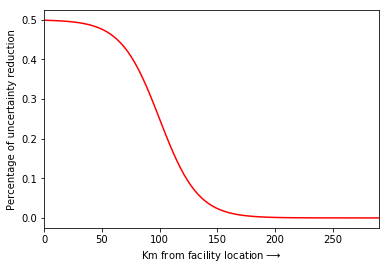

In [28]:
sig_height = 0.5
sig_length = 100 # TODO should be more or less equal to expected max_cov distance. 
sig_steepness = -0.06 #steepness chosen arbitrarily to create nice curve

sigmoid = lambda x: sig_height / (1 + np.exp(- sig_steepness*(x-sig_length)))
# x=np.linspace(0,10,10)
y=np.linspace(0,sig_length*3,100)
plt.plot(y,sigmoid(y),'r')
plt.xlabel(r'Km from facility location$\longrightarrow$')
plt.ylabel("Percentage of uncertainty reduction")
plt.xlim((0,sig_length*2.9))
plt.show()

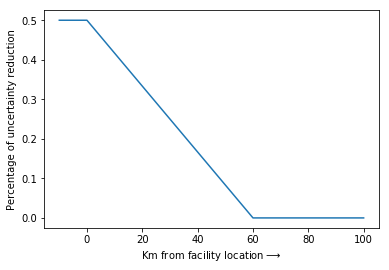

In [29]:
y=np.linspace(-10,100,100)
plt.plot(y,linear(y, 60, plotting=True))
plt.xlabel(r'Km from facility location$\longrightarrow$')
plt.ylabel("Percentage of uncertainty reduction")
# plt.xlim((0,sig_length*2.9))
plt.show()

#### Micromodel changing uncertainty space

##### TODO: Describe and formalise in report

In [30]:
def new_est_low_up(row, fl_n, method="linear", lin_max_info_reduction = 100):
    """
    method: linear or sigmoid
    XXTODO: check params for sigmoid&linear function XXTODO
    Validated"""
    row_label = row.name[3:]
    fl_label = "FL{}".format(fl_n)
    dist = time_matrix.loc[fl_label, row_label]
    if method == "linear":

        unc_red = linear(dist/1000, lin_max_info_reduction)
    if method == "sigmoid":

        unc_red == sigmoid (dist)
    be_new = row['best_estimate'] + (row['actual']-row['best_estimate'])* unc_red
    low_new = be_new - 0.5 * (row['upper']-row['lower']) * (1-unc_red)
    up_new = be_new + 0.5 * (row['upper']-row['lower']) * (1-unc_red)
    return low_new, be_new, up_new

In [31]:
def change_decision_based_uncertainty(df, fls_dict):
    """
    input: current df, integer operational FLs
    returns changed dataframe
    """ 
    fls = [int(key[3:]) for key,val in fls_dict.items() if val == 1]
    
    df2 = df.copy(deep=True)
    for fl in fls:
        print(fl,type(fl))
        df2['lower'], df2['best_estimate'], df2['upper'] = zip(
            *df2.apply(lambda row: new_est_low_up(row, 13), axis=1))
    return df2


# df3 = change_decision_based_uncertainty(df_test, [2, 3])

In [34]:
periods = 2  # 1 location per period -> locations = periods

global_node_counter = 0

start_situation = {key: 0 for key in FLs.Name}
global_policy_tree = {start_label: start_situation}
global_label_tree = {
    "p{}".format(p, global_node_counter): []
    if p != 0 else ["{}".format(start_label)]
    for p in range(periods + 1)
}

EMA_model_dict = {}  # XX somewhere else: global
print("starting label:", start_label)

for p in range(periods):
    for node_i, node in enumerate(list(global_label_tree["p{}".format(p)])):
        #         print("|", p, node)
        if p < periods:
            print("Do mordm, in period:", p, "label:", node, "policy:",
                  global_policy_tree[node])
            #             new_pols = ["a", "b", "c"]
            new_pols = MORDM(
                current=global_policy_tree[node],
                n_scenarios=100,
                trace_label=node,
                table_dir="Data/route_times.csv",
                saving_dir="results/mpmordm_test_with_routes/")
            for new_pol in new_pols:
                # Create new label
                global_node_counter += 1
                new_label = node + "p{}n{}".format(p + 1, global_node_counter)
                print("result:|||", new_label)
                # Create new branch
                global_label_tree["p{}".format(p + 1)].append(new_label)
                # add new policy
                global_policy_tree[new_label] = new_pol
                # change information based on policy
                #TODO not implemented yet
                #                 global_dfs_var_unc_data[new_label] = global_dfs_var_unc_data[start_label]
                print(new_pol)
                #change uncertainty based on new policy implementations
                global_dfs_var_unc_data[
                    new_label] = change_decision_based_uncertainty(
                        global_dfs_var_unc_data[node], new_pol)

        else:
            print(p, "if you see this, sth went wrong.")

#     print("__end_period:",p)

starting label: p0n0
Do mordm, in period: 0 label: p0n0 policy: {'FLO0': 0, 'FLO1': 0, 'FLO2': 0, 'FLO3': 0, 'FLO4': 0, 'FLO5': 0, 'FLO6': 0, 'FLO7': 0, 'FLO8': 0, 'FLO9': 0, 'FLO10': 0, 'FLO11': 0, 'FLO12': 0, 'FLO13': 0, 'FLO14': 0, 'FLO15': 0, 'FLO16': 0, 'FLO17': 0, 'FLO18': 0, 'FLO19': 0}
XXX (19, 4)


[MainProcess/INFO] performing 100 scenarios * 6 policies * 1 model(s) = 600 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 420 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 540 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] experiments finished


Total time:5.251543045043945 
 time per run = 0.008752571741739908


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\mpmordm_test_with_routes\p0n0.tar.gz


result:||| p0n0p1n1
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 1.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
2 <class 'int'>
result:||| p0n0p1n2
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 1.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
6 <class 'int'>
result:||| p0n0p1n3
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
result:||| p0n0p1n4
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4'

[MainProcess/INFO] performing 100 scenarios * 3 policies * 1 model(s) = 300 experiments
[MainProcess/INFO] performing experiments sequentially


 (16, 4)


[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 210 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 270 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\mpmordm_test_with_routes\p0n0p1n1.tar.gz


Total time:2.943507194519043 
 time per run = 0.00981169064839681
result:||| p0n0p1n1p2n6
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 1.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 1.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
2 <class 'int'>
6 <class 'int'>
result:||| p0n0p1n1p2n7
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 1.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
2 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n1p2n8
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 1.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 1.0, 'FLO18': 0.0

[MainProcess/INFO] performing 100 scenarios * 2 policies * 1 model(s) = 200 experiments
[MainProcess/INFO] performing experiments sequentially


XXX (13, 4)


[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\mpmordm_test_with_routes\p0n0p1n2.tar.gz


Total time:2.104809045791626 
 time per run = 0.01052404522895813
result:||| p0n0p1n2p2n9
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 1.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 1.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
2 <class 'int'>
6 <class 'int'>
result:||| p0n0p1n2p2n10
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 1.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 1.0, 'FLO18': 0.0, 'FLO19': 0.0}
6 <class 'int'>
17 <class 'int'>
Do mordm, in period: 1 label: p0n0p1n3 policy: {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'F

[MainProcess/INFO] performing 100 scenarios * 3 policies * 1 model(s) = 300 experiments
[MainProcess/INFO] performing experiments sequentially


XXX (16, 4)


[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 210 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 270 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\mpmordm_test_with_routes\p0n0p1n3.tar.gz


Total time:3.0022873878479004 
 time per run = 0.010007624626159667
result:||| p0n0p1n3p2n11
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 1.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
6 <class 'int'>
7 <class 'int'>
result:||| p0n0p1n3p2n12
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n3p2n13
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 1.0, 'FLO18'

[MainProcess/INFO] performing 100 scenarios * 4 policies * 1 model(s) = 400 experiments
[MainProcess/INFO] performing experiments sequentially


XXX (16, 4)


[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\mpmordm_test_with_routes\p0n0p1n4.tar.gz


Total time:4.066678762435913 
 time per run = 0.010166696906089782
result:||| p0n0p1n4p2n14
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n15
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 1.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
12 <class 'int'>
13 <class 'int'>
result:||| p0n0p1n4p2n16
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18

[MainProcess/INFO] performing 100 scenarios * 5 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] performing experiments sequentially


XXX (17, 4)


[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished


Total time:4.397490739822388 
 time per run = 0.008794981479644776


[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\mpmordm_test_with_routes\p0n0p1n5.tar.gz


result:||| p0n0p1n5p2n17
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 1.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
7 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n18
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 1.0, 'FLO13': 0.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
12 <class 'int'>
14 <class 'int'>
result:||| p0n0p1n5p2n19
{'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 1.0, 'FLO14': 1.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0}
13 <class 'int'>
14 <class 'int'>
result:||| 

## Save results

In [334]:
global_label_tree
EMA_model_dict
global_dfs_var_unc_data
global_fixed_unc
global_policy_tree
1

1

In [339]:
import pickle

# Store data (serialize)
with open('results/mpmordm/picklejar/test_mpmordm_objs_lEdfp.pickle',
          'wb') as handle:
    pickle.dump(
        (global_label_tree, EMA_model_dict, global_dfs_var_unc_data,
         global_fixed_unc, global_policy_tree),
        handle,
        protocol=pickle.HIGHEST_PROTOCOL)


In [37]:
import pickle
# Load data (deserialize)
with open('results/mpmordm/picklejar/test_mpmordm_objs_lEdfp.pickle',
          'rb') as handle:
    global_label_tree2, EMA_model_dict2, global_dfs_var_unc_data2, global_fixed_unc2, global_policy_tree2 = pickle.load(
        handle)

In [38]:
(global_label_tree2, EMA_model_dict2, global_dfs_var_unc_data2,
         global_fixed_unc2, global_policy_tree2)

({'p0': ['p0n0'],
  'p1': ['p0n0p1n1', 'p0n0p1n2', 'p0n0p1n3'],
  'p2': ['p0n0p1n1p2n4',
   'p0n0p1n1p2n5',
   'p0n0p1n1p2n6',
   'p0n0p1n2p2n7',
   'p0n0p1n2p2n8',
   'p0n0p1n2p2n9',
   'p0n0p1n3p2n10',
   'p0n0p1n3p2n11',
   'p0n0p1n3p2n12'],
  'p3': ['p0n0p1n1p2n4p3n13',
   'p0n0p1n1p2n4p3n14',
   'p0n0p1n1p2n4p3n15',
   'p0n0p1n1p2n5p3n16',
   'p0n0p1n1p2n5p3n17',
   'p0n0p1n1p2n5p3n18',
   'p0n0p1n1p2n6p3n19',
   'p0n0p1n1p2n6p3n20',
   'p0n0p1n1p2n6p3n21',
   'p0n0p1n2p2n7p3n22',
   'p0n0p1n2p2n7p3n23',
   'p0n0p1n2p2n7p3n24',
   'p0n0p1n2p2n8p3n25',
   'p0n0p1n2p2n8p3n26',
   'p0n0p1n2p2n8p3n27',
   'p0n0p1n2p2n9p3n28',
   'p0n0p1n2p2n9p3n29',
   'p0n0p1n2p2n9p3n30',
   'p0n0p1n3p2n10p3n31',
   'p0n0p1n3p2n10p3n32',
   'p0n0p1n3p2n10p3n33',
   'p0n0p1n3p2n11p3n34',
   'p0n0p1n3p2n11p3n35',
   'p0n0p1n3p2n11p3n36',
   'p0n0p1n3p2n12p3n37',
   'p0n0p1n3p2n12p3n38',
   'p0n0p1n3p2n12p3n39'],
  'p4': ['p0n0p1n1p2n4p3n13p4n40',
   'p0n0p1n1p2n4p3n13p4n41',
   'p0n0p1n1p2n4p3n13p4n42'

## check what's in the results 

In [39]:
EMA_model_dict

{'p0n0': <ema_workbench.em_framework.model.Model at 0x2113070cac8>,
 'p0n0p1n1': <ema_workbench.em_framework.model.Model at 0x21130711780>,
 'p0n0p1n2': <ema_workbench.em_framework.model.Model at 0x21130b825f8>,
 'p0n0p1n3': <ema_workbench.em_framework.model.Model at 0x211305ea6a0>,
 'p0n0p1n4': <ema_workbench.em_framework.model.Model at 0x21130b690f0>,
 'p0n0p1n5': <ema_workbench.em_framework.model.Model at 0x21130b69240>}

In [40]:
for key in global_policy_tree.keys():
    poldict = global_policy_tree[key]
    print(key,[key2 for key2 in poldict if poldict[key2]==1])

p0n0 []
p0n0p1n1 ['FLO2']
p0n0p1n2 ['FLO6']
p0n0p1n3 ['FLO7']
p0n0p1n4 ['FLO13']
p0n0p1n5 ['FLO14']
p0n0p1n1p2n6 ['FLO2', 'FLO6']
p0n0p1n1p2n7 ['FLO2', 'FLO13']
p0n0p1n1p2n8 ['FLO2', 'FLO17']
p0n0p1n2p2n9 ['FLO2', 'FLO6']
p0n0p1n2p2n10 ['FLO6', 'FLO17']
p0n0p1n3p2n11 ['FLO6', 'FLO7']
p0n0p1n3p2n12 ['FLO7', 'FLO13']
p0n0p1n3p2n13 ['FLO7', 'FLO17']
p0n0p1n4p2n14 ['FLO7', 'FLO13']
p0n0p1n4p2n15 ['FLO12', 'FLO13']
p0n0p1n4p2n16 ['FLO13', 'FLO14']
p0n0p1n5p2n17 ['FLO7', 'FLO14']
p0n0p1n5p2n18 ['FLO12', 'FLO14']
p0n0p1n5p2n19 ['FLO13', 'FLO14']
p0n0p1n5p2n20 ['FLO14', 'FLO17']


In [41]:
# only those nodes that branch from n2
for key in global_policy_tree.keys():
    if "n2" in key:
        poldict = global_policy_tree[key]
        print(key,[key2 for key2 in poldict if poldict[key2]==1])

p0n0p1n2 ['FLO6']
p0n0p1n2p2n9 ['FLO2', 'FLO6']
p0n0p1n2p2n10 ['FLO6', 'FLO17']
p0n0p1n5p2n20 ['FLO14', 'FLO17']


In [196]:
# all FLs
set_fls = set()
for key in global_policy_tree.keys():
    poldict = global_policy_tree[key]
    for fl in ([key2 for key2 in poldict if poldict[key2]==1]):
        set_fls.add(fl)
set_fls

{'FLO0', 'FLO17', 'FLO9'}

## plot changes uncertainty ranges

In [231]:
global_label_tree

{'p0': ['p0n0'],
 'p1': ['p0n0p1n1', 'p0n0p1n2', 'p0n0p1n3'],
 'p2': ['p0n0p1n1p2n4',
  'p0n0p1n1p2n5',
  'p0n0p1n1p2n6',
  'p0n0p1n2p2n7',
  'p0n0p1n2p2n8',
  'p0n0p1n2p2n9',
  'p0n0p1n3p2n10',
  'p0n0p1n3p2n11',
  'p0n0p1n3p2n12'],
 'p3': ['p0n0p1n1p2n4p3n13',
  'p0n0p1n1p2n4p3n14',
  'p0n0p1n1p2n4p3n15',
  'p0n0p1n1p2n5p3n16',
  'p0n0p1n1p2n5p3n17',
  'p0n0p1n1p2n5p3n18',
  'p0n0p1n1p2n6p3n19',
  'p0n0p1n1p2n6p3n20',
  'p0n0p1n1p2n6p3n21',
  'p0n0p1n2p2n7p3n22',
  'p0n0p1n2p2n7p3n23',
  'p0n0p1n2p2n7p3n24',
  'p0n0p1n2p2n8p3n25',
  'p0n0p1n2p2n8p3n26',
  'p0n0p1n2p2n8p3n27',
  'p0n0p1n2p2n9p3n28',
  'p0n0p1n2p2n9p3n29',
  'p0n0p1n2p2n9p3n30',
  'p0n0p1n3p2n10p3n31',
  'p0n0p1n3p2n10p3n32',
  'p0n0p1n3p2n10p3n33',
  'p0n0p1n3p2n11p3n34',
  'p0n0p1n3p2n11p3n35',
  'p0n0p1n3p2n11p3n36',
  'p0n0p1n3p2n12p3n37',
  'p0n0p1n3p2n12p3n38',
  'p0n0p1n3p2n12p3n39'],
 'p4': ['p0n0p1n1p2n4p3n13p4n40',
  'p0n0p1n1p2n4p3n13p4n41',
  'p0n0p1n1p2n4p3n13p4n42',
  'p0n0p1n1p2n4p3n14p4n43',
  'p0n0p1n1

In [224]:
def shorten_labels(label,lab_list = []):
    if "p" in label:
        for i in range(len(label)):
            if label[-i-1] == "p":
                flag = i
                break
        new_label = label[:-i-1]
        lab_list.append(label)
        return shorten_labels(new_label,lab_list), lab_list


def find_full_trace(label):
    b=[]
    a,b = shorten_labels(label,b)
    return b

In [319]:
#neem de eerste uit de laatste periode
label= global_label_tree[sorted(global_label_tree.keys())[-1]][0]
# # for i in global_label_tree.values():
# #     pass

testlabels = list(reversed(find_full_trace(label)))

In [321]:
from functools import reduce
testdfs = [global_dfs_var_unc_data[l] for l in testlabels]

In [322]:
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), testdfs)

In [323]:
test_cols = []
for i in range(len(testdfs)):
#     print("a")
    for j in [df_final.columns[-4:]]:
#         print("b")
        test_cols.extend (j+"{}".format(i))


In [324]:
df_final.columns = test_cols

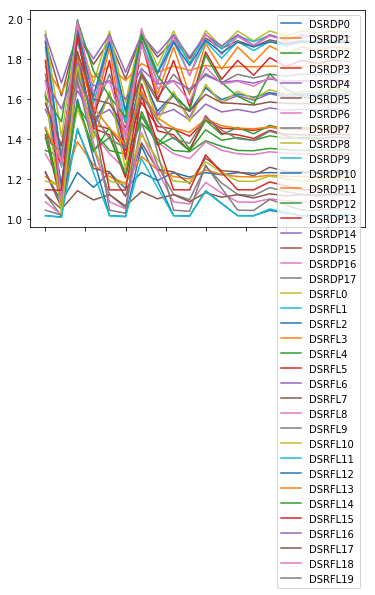

In [325]:
df_final.T.plot.line()

In [326]:
df_final

,actual0,lower0,upper0,best_estimate0,actual1,lower1,upper1,best_estimate1,actual2,lower2,upper2,best_estimate2,actual3,lower3,upper3,best_estimate3,actual4,lower4,upper4,best_estimate4
DSRDP0,1.015003,1.008658,1.598299,1.303479,1.015003,1.011212,1.363565,1.187388,1.015003,1.013649,1.139472,1.076560,1.015003,1.014714,1.041563,1.028139,1.015003,1.014966,1.018390,1.016678
DSRDP1,1.858495,1.106396,1.914770,1.510583,1.858495,1.345280,1.896896,1.621088,1.858495,1.619523,1.876376,1.747949,1.858495,1.782564,1.864177,1.823370,1.858495,1.842032,1.859727,1.850879
DSRDP2,1.341087,1.310102,1.567980,1.439041,1.341087,1.322582,1.476597,1.399589,1.341087,1.334486,1.389423,1.361954,1.341087,1.339681,1.351384,1.345532,1.341087,1.340908,1.342397,1.341652
DSRDP3,1.448467,1.265519,1.675949,1.470734,1.448467,1.341866,1.581018,1.461442,1.448467,1.412274,1.493471,1.452872,1.448467,1.441307,1.457371,1.449339,1.448467,1.447642,1.449494,1.448568
DSRDP4,1.615594,1.094348,1.818576,1.456462,1.615594,1.305571,1.736323,1.520947,1.615594,1.505922,1.658303,1.582112,1.615594,1.592519,1.624580,1.608549,1.615594,1.612706,1.616719,1.614713
DSRDP5,1.890072,1.614069,1.929471,1.771770,1.890072,1.699742,1.917241,1.808492,1.890072,1.799562,1.902992,1.851277,1.890072,1.860391,1.894308,1.877350,1.890072,1.883360,1.891030,1.887195
DSRDP6,1.324616,1.179957,1.677272,1.428614,1.324616,1.244987,1.518739,1.381863,1.324616,1.300488,1.383436,1.341962,1.324616,1.320592,1.334427,1.327509,1.324616,1.324246,1.325517,1.324882
DSRDP7,1.121350,1.012851,1.694784,1.353817,1.121350,1.053571,1.479569,1.266570,1.121350,1.094900,1.261141,1.178020,1.121350,1.114902,1.155428,1.135165,1.121350,1.120368,1.126539,1.123454
DSRDP8,1.938678,1.409590,1.945943,1.677767,1.938678,1.582659,1.943567,1.763113,1.938678,1.777479,1.940892,1.859185,1.938678,1.889565,1.939353,1.914459,1.938678,1.928609,1.938817,1.933713
DSRDP9,1.915348,1.278802,1.943758,1.611280,1.915348,1.532850,1.932420,1.732635,1.915348,1.777237,1.921512,1.849375,1.915348,1.885382,1.916686,1.901034,1.915348,1.911441,1.915523,1.913482


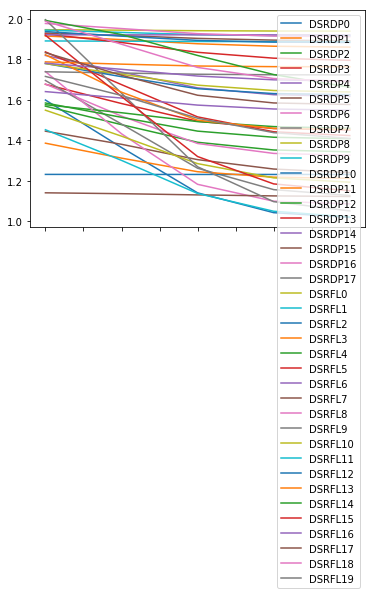

In [327]:
pd.DataFrame({"name{}".format(i):df['upper'] for i,df in enumerate(testdfs)}).T.plot()

In [257]:
global_dfs_var_unc_data['p0n0']

,actual,lower,upper,best_estimate
DSRDP0,1.015003,1.008658,1.598299,1.303479
DSRDP1,1.858495,1.106396,1.914770,1.510583
DSRDP2,1.341087,1.310102,1.567980,1.439041
DSRDP3,1.448467,1.265519,1.675949,1.470734
DSRDP4,1.615594,1.094348,1.818576,1.456462
DSRDP5,1.890072,1.614069,1.929471,1.771770
DSRDP6,1.324616,1.179957,1.677272,1.428614
DSRDP7,1.121350,1.012851,1.694784,1.353817
DSRDP8,1.938678,1.409590,1.945943,1.677767
DSRDP9,1.915348,1.278802,1.943758,1.611280


In [229]:
label

'p0n0p1n1p2n4p3n13p4n40'

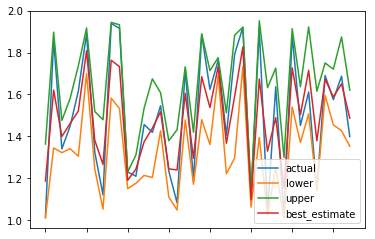

In [59]:
global_dfs_var_unc_data['p0n0p1n2'].plot()#kind='bar')

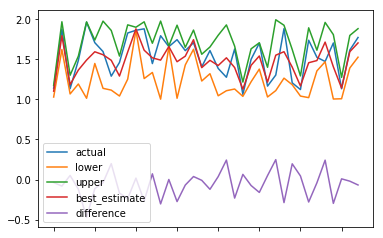

In [124]:
df_test.plot()

#### test functions 

# check for size of dictionary and its items

In [46]:
from __future__ import print_function
from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)


# ##### Example call #####

# if __name__ == '__main__':
#     d = dict(a=1, b=2, c=3, d=[4,5,6,7], e='a string of chars')
#     print(total_size(d, verbose=True))

In [47]:
print(total_size(global_dfs_var_unc_data, verbose=True))

4704 <class 'dict'> {'p0n0':            ac...      1.524229, 'p0n0p1n1':            ac...      1.487009, 'p0n0p1n1p2n4':            ac...      1.442561, 'p0n0p1n1p2n4p3n13':            ac...      1.414339, ...}
53 <class 'str'> 'p0n0'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.524229
57 <class 'str'> 'p0n0p1n1'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.487009
57 <class 'str'> 'p0n0p1n2'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.487009
57 <class 'str'> 'p0n0p1n3'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.487009
61 <class 'str'> 'p0n0p1n1p2n4'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.442561
61 <class 'str'> 'p0n0p1n1p2n5'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.442561
61 <class 'str'> 'p0n0p1n1p2n6'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.442561
61 <class 'str'> 'p0n0p1n2p2n7'
4220 <class 'pandas.core.frame.Data

472179


 <class 'pandas.core.frame.DataFrame'>            ac...      1.403051
73 <class 'str'> 'p0n0p1n3p2n12p3n39p4n107'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.403051
73 <class 'str'> 'p0n0p1n3p2n12p3n39p4n108'
4220 <class 'pandas.core.frame.DataFrame'>            ac...      1.403051
